In [1]:
import torch
from models.resnet import load_resnet_model
from models.swin3D import load_swin3d
from models.swin import load_swin

from utils.train import train_model
from utils.dataloader import create_dataloader, create_dataset

from utils.utils import sorted_file_paths
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
from matplotlib import pyplot as plt
from loss.balanced_MSE_loss import BMCLoss

2024-05-02 18:23:11.183735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 18:23:11.183786: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 18:23:11.184565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 18:23:11.190851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 18:23:12.615824: W tensorflow/compiler/tf2

# Setting up common variables for all experiments

In [2]:
LR = 0.001
EPOCH = 30
GAMMA = 0.95

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_files = sorted_file_paths('./data/records_location/train/')
val_files = sorted_file_paths('./data/records_location/val/')

train_dataset = create_dataset(train_files)
val_dataset = create_dataset(val_files)


train_loader = create_dataloader(train_dataset, 32)
val_loader = create_dataloader(val_dataset, 32)

training_labels = train_dataset.all_labels.numpy()

# Experiment 0: L2 loss Swin 3d

In [4]:
ex = 'experiments/ex_0'
loss =  nn.MSELoss()
model = load_swin3d("base")
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex,epochs=EPOCH)

Epoch 1/30, Train Loss: 1.4297, Train R2: -6.0945, Train weighted MAE: 0.4557,Val Loss: 0.2163, Val R2: -0.0710, Val weighted MAE: 0.3460
Model saved as experiments/ex_0/checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.2211, Train R2: -0.0970, Train weighted MAE: 0.3908,Val Loss: 0.2077, Val R2: -0.0285, Val weighted MAE: 0.4121
Model saved as experiments/ex_0/checkpoint_epoch_2.pth
Epoch 3/30, Train Loss: 0.2183, Train R2: -0.0832, Train weighted MAE: 0.3904,Val Loss: 0.2114, Val R2: -0.0469, Val weighted MAE: 0.4208
Epoch 4/30, Train Loss: 0.2115, Train R2: -0.0496, Train weighted MAE: 0.3869,Val Loss: 0.2170, Val R2: -0.0745, Val weighted MAE: 0.4315
Epoch 5/30, Train Loss: 0.2106, Train R2: -0.0451, Train weighted MAE: 0.3867,Val Loss: 0.2033, Val R2: -0.0068, Val weighted MAE: 0.3967
Model saved as experiments/ex_0/checkpoint_epoch_5.pth
Epoch 6/30, Train Loss: 0.2106, Train R2: -0.0451, Train weighted MAE: 0.3891,Val Loss: 0.2077, Val R2: -0.0285, Val weighted MAE: 0.4120
Epoch 7

# Experiment 1: L2 loss Swin 3d tiny

In [5]:
ex = 'experiments/ex_1'
loss =  nn.MSELoss()
model = load_swin3d("tiny")
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex, epochs=EPOCH)

Epoch 1/30, Train Loss: 0.2535, Train R2: -0.2579, Train weighted MAE: 0.3845,Val Loss: 0.1830, Val R2: 0.0940, Val weighted MAE: 0.3816
Model saved as experiments/ex_1/checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.2081, Train R2: -0.0325, Train weighted MAE: 0.3786,Val Loss: 0.2131, Val R2: -0.0553, Val weighted MAE: 0.4263
Epoch 3/30, Train Loss: 0.2120, Train R2: -0.0520, Train weighted MAE: 0.3799,Val Loss: 0.2018, Val R2: 0.0007, Val weighted MAE: 0.4069
Epoch 4/30, Train Loss: 0.4151, Train R2: -1.0597, Train weighted MAE: 0.3899,Val Loss: 0.2021, Val R2: -0.0009, Val weighted MAE: 0.3882
Epoch 5/30, Train Loss: 0.2236, Train R2: -0.1098, Train weighted MAE: 0.3912,Val Loss: 0.2161, Val R2: -0.0699, Val weighted MAE: 0.4299
Epoch 6/30, Train Loss: 0.2521, Train R2: -0.2510, Train weighted MAE: 0.3981,Val Loss: 0.2391, Val R2: -0.1839, Val weighted MAE: 0.3292
Epoch 7/30, Train Loss: 0.2455, Train R2: -0.2184, Train weighted MAE: 0.3973,Val Loss: 0.2123, Val R2: -0.0514, Val we

# Experiment 2: L2 loss Resnet 50

In [3]:
ex = 'experiments/ex_2'
loss =  nn.MSELoss()
model = load_resnet_model('resnet50', num_classes=1)
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex, epochs=EPOCH)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.1985, Train R2: 0.0150, Train weighted MAE: 0.3072,Val Loss: 0.1484, Val R2: 0.2653, Val weighted MAE: 0.2414
Model saved as experiments/ex_2/checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.1045, Train R2: 0.4816, Train weighted MAE: 0.2468,Val Loss: 0.0925, Val R2: 0.5420, Val weighted MAE: 0.2283
Model saved as experiments/ex_2/checkpoint_epoch_2.pth
Epoch 3/30, Train Loss: 0.0921, Train R2: 0.5432, Train weighted MAE: 0.2302,Val Loss: 0.1043, Val R2: 0.4837, Val weighted MAE: 0.2203
Epoch 4/30, Train Loss: 0.0822, Train R2: 0.5920, Train weighted MAE: 0.2145,Val Loss: 0.1189, Val R2: 0.4110, Val weighted MAE: 0.2633
Epoch 5/30, Train Loss: 0.0737, Train R2: 0.6342, Train weighted MAE: 0.2000,Val Loss: 0.1098, Val R2: 0.4562, Val weighted MAE: 0.2759
Epoch 6/30, Train Loss: 0.0719, Train R2: 0.6434, Train weighted MAE: 0.1912,Val Loss: 0.1118, Val R2: 0.4462, Val weighted MAE: 0.3035
Epoch 7/30, Train Loss: 0.0636, Train R2: 0.6842, Train weighted MAE: 0.18

# Experiment 3: L2 Loss Swin

In [4]:
ex = 'experiments/ex_3'
loss =  nn.MSELoss()
model = load_swin()
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex, epochs=EPOCH)

Epoch 1/30, Train Loss: 0.7061, Train R2: -2.5041, Train weighted MAE: 0.4350,Val Loss: 0.2071, Val R2: -0.0253, Val weighted MAE: 0.4103
Model saved as experiments/ex_3/checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.2229, Train R2: -0.1062, Train weighted MAE: 0.3911,Val Loss: 0.2102, Val R2: -0.0409, Val weighted MAE: 0.4181
Epoch 3/30, Train Loss: 0.2185, Train R2: -0.0843, Train weighted MAE: 0.3890,Val Loss: 0.2090, Val R2: -0.0351, Val weighted MAE: 0.4153
Epoch 4/30, Train Loss: 0.2124, Train R2: -0.0538, Train weighted MAE: 0.3856,Val Loss: 0.2264, Val R2: -0.1210, Val weighted MAE: 0.4466
Epoch 5/30, Train Loss: 0.2128, Train R2: -0.0561, Train weighted MAE: 0.3855,Val Loss: 0.2250, Val R2: -0.1142, Val weighted MAE: 0.4446
Epoch 6/30, Train Loss: 0.2101, Train R2: -0.0426, Train weighted MAE: 0.3862,Val Loss: 0.2415, Val R2: -0.1960, Val weighted MAE: 0.4668
Epoch 7/30, Train Loss: 0.2095, Train R2: -0.0394, Train weighted MAE: 0.3843,Val Loss: 0.2341, Val R2: -0.1594, Val 

# Experiment 4: L3 loss

In [3]:
from loss.weighted_L3_loss import L3Loss

ex = 'experiments/ex_4/'
loss =  L3Loss()
model = load_resnet_model('resnet50', num_classes=1)
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex, epochs=EPOCH)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.3073, Train R2: -0.2181, Train weighted MAE: 0.3178,Val Loss: 0.0617, Val R2: 0.4817, Val weighted MAE: 0.2725
Model saved as experiments/ex_4//checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.0586, Train R2: 0.4707, Train weighted MAE: 0.2468,Val Loss: 0.0559, Val R2: 0.5096, Val weighted MAE: 0.2534
Model saved as experiments/ex_4//checkpoint_epoch_2.pth
Epoch 3/30, Train Loss: 0.0481, Train R2: 0.5346, Train weighted MAE: 0.2297,Val Loss: 0.0550, Val R2: 0.5201, Val weighted MAE: 0.2497
Model saved as experiments/ex_4//checkpoint_epoch_3.pth
Epoch 4/30, Train Loss: 0.0402, Train R2: 0.5829, Train weighted MAE: 0.2156,Val Loss: 0.0540, Val R2: 0.5257, Val weighted MAE: 0.2420
Model saved as experiments/ex_4//checkpoint_epoch_4.pth
Epoch 5/30, Train Loss: 0.0316, Train R2: 0.6388, Train weighted MAE: 0.1983,Val Loss: 0.0589, Val R2: 0.4864, Val weighted MAE: 0.2358
Epoch 6/30, Train Loss: 0.0225, Train R2: 0.7062, Train weighted MAE: 0.1752,Val Loss: 0.0740, 

# Experiment 5: Weighted MSE with dense_weight model, alpha = 0.25

In [4]:
from loss.weighted_MSE_loss import WeightedMSELoss
from loss.dense_weight import DenseWeight

In [5]:
ex = 'experiments/ex_5'

dense_weight_model = DenseWeight(0.25)
dense_weight_model.fit(training_labels)
loss =  WeightedMSELoss(dense_weight_model)
model = load_resnet_model('resnet50', num_classes=1)
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex, epochs=EPOCH)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.2056, Train R2: 0.0078, Train weighted MAE: 0.2874,Val Loss: 0.1079, Val R2: 0.4929, Val weighted MAE: 0.2556
Model saved as experiments/ex_5/checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.1044, Train R2: 0.5034, Train weighted MAE: 0.2375,Val Loss: 0.1084, Val R2: 0.4987, Val weighted MAE: 0.2645
Epoch 3/30, Train Loss: 0.0931, Train R2: 0.5557, Train weighted MAE: 0.2203,Val Loss: 0.1047, Val R2: 0.5116, Val weighted MAE: 0.2473
Model saved as experiments/ex_5/checkpoint_epoch_3.pth
Epoch 4/30, Train Loss: 0.0836, Train R2: 0.6003, Train weighted MAE: 0.2070,Val Loss: 0.1290, Val R2: 0.4157, Val weighted MAE: 0.3013
Epoch 5/30, Train Loss: 0.0809, Train R2: 0.6119, Train weighted MAE: 0.1997,Val Loss: 0.1129, Val R2: 0.4485, Val weighted MAE: 0.2106
Epoch 6/30, Train Loss: 0.0781, Train R2: 0.6239, Train weighted MAE: 0.1889,Val Loss: 0.1715, Val R2: 0.2092, Val weighted MAE: 0.3326
Epoch 7/30, Train Loss: 0.0780, Train R2: 0.6237, Train weighted MAE: 0.18

# Experiment 6: Weighted MSE with dense_weight model, alpha = 0.5

In [6]:
ex = 'experiments/ex_6/'

dense_weight_model = DenseWeight(0.5)
dense_weight_model.fit(training_labels)
loss =  WeightedMSELoss(dense_weight_model)
model = load_resnet_model('resnet50', num_classes=1)
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex, epochs=EPOCH)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.2299, Train R2: -0.0715, Train weighted MAE: 0.2779,Val Loss: 0.1254, Val R2: 0.3943, Val weighted MAE: 0.2304
Model saved as experiments/ex_6//checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.1081, Train R2: 0.5036, Train weighted MAE: 0.2259,Val Loss: 0.1063, Val R2: 0.5457, Val weighted MAE: 0.2496
Model saved as experiments/ex_6//checkpoint_epoch_2.pth
Epoch 3/30, Train Loss: 0.0928, Train R2: 0.5701, Train weighted MAE: 0.2072,Val Loss: 0.1080, Val R2: 0.5394, Val weighted MAE: 0.2455
Epoch 4/30, Train Loss: 0.0788, Train R2: 0.6316, Train weighted MAE: 0.1868,Val Loss: 0.1355, Val R2: 0.4398, Val weighted MAE: 0.2906
Epoch 5/30, Train Loss: 0.0738, Train R2: 0.6517, Train weighted MAE: 0.1763,Val Loss: 0.1190, Val R2: 0.4528, Val weighted MAE: 0.2431
Epoch 6/30, Train Loss: 0.0716, Train R2: 0.6598, Train weighted MAE: 0.1698,Val Loss: 0.1302, Val R2: 0.3629, Val weighted MAE: 0.2124
Epoch 7/30, Train Loss: 0.0692, Train R2: 0.6682, Train weighted MAE: 0

# Experiment 7: weighted sampling with replacement for a more balanced dataset alpha = 0.25

In [8]:
ex = 'experiments/ex_7/'

dense_weight_model = DenseWeight(0.25)
dense_weight_model.fit(training_labels)

balanced_train_loader = create_dataloader(train_dataset, 64, dense_weight_model)

loss =  nn.MSELoss()
model = load_resnet_model('resnet50', num_classes=1)
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, balanced_train_loader, val_loader, device, ex, epochs=EPOCH)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.2764, Train R2: -0.2554, Train weighted MAE: 0.3148,Val Loss: 0.1063, Val R2: 0.4735, Val weighted MAE: 0.2696
Model saved as experiments/ex_7//checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.0921, Train R2: 0.5875, Train weighted MAE: 0.2214,Val Loss: 0.1061, Val R2: 0.4747, Val weighted MAE: 0.2428
Model saved as experiments/ex_7//checkpoint_epoch_2.pth
Epoch 3/30, Train Loss: 0.0823, Train R2: 0.6349, Train weighted MAE: 0.2052,Val Loss: 0.0954, Val R2: 0.5275, Val weighted MAE: 0.2156
Model saved as experiments/ex_7//checkpoint_epoch_3.pth
Epoch 4/30, Train Loss: 0.0768, Train R2: 0.6519, Train weighted MAE: 0.1958,Val Loss: 0.1061, Val R2: 0.4747, Val weighted MAE: 0.2715
Epoch 5/30, Train Loss: 0.0627, Train R2: 0.7054, Train weighted MAE: 0.1746,Val Loss: 0.1272, Val R2: 0.3699, Val weighted MAE: 0.3118
Epoch 6/30, Train Loss: 0.0561, Train R2: 0.7444, Train weighted MAE: 0.1581,Val Loss: 0.1381, Val R2: 0.3161, Val weighted MAE: 0.2047
Epoch 7/30, Tra

# Experiment 8: weighted sampling with replacement for a more balanced dataset, alpha = 0.5

In [9]:
ex = 'experiments/ex_8'

dense_weight_model = DenseWeight(0.5)
dense_weight_model.fit(training_labels)

balanced_train_loader = create_dataloader(train_dataset, 64, dense_weight_model)

loss =  nn.MSELoss()
model = load_resnet_model('resnet50', num_classes=1)
optimizer = optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, balanced_train_loader, val_loader, device, ex, epochs=EPOCH)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30, Train Loss: 0.3038, Train R2: -0.2567, Train weighted MAE: 0.2995,Val Loss: 0.1399, Val R2: 0.3073, Val weighted MAE: 0.3357
Model saved as experiments/ex_8/checkpoint_epoch_1.pth
Epoch 2/30, Train Loss: 0.1072, Train R2: 0.5789, Train weighted MAE: 0.2203,Val Loss: 0.1245, Val R2: 0.3833, Val weighted MAE: 0.2491
Model saved as experiments/ex_8/checkpoint_epoch_2.pth
Epoch 3/30, Train Loss: 0.0931, Train R2: 0.6145, Train weighted MAE: 0.2035,Val Loss: 0.1008, Val R2: 0.5006, Val weighted MAE: 0.2390
Model saved as experiments/ex_8/checkpoint_epoch_3.pth
Epoch 4/30, Train Loss: 0.0798, Train R2: 0.6694, Train weighted MAE: 0.1906,Val Loss: 0.1421, Val R2: 0.2962, Val weighted MAE: 0.2107
Epoch 5/30, Train Loss: 0.0774, Train R2: 0.6821, Train weighted MAE: 0.1834,Val Loss: 0.1121, Val R2: 0.4450, Val weighted MAE: 0.2815
Epoch 6/30, Train Loss: 0.0604, Train R2: 0.7532, Train weighted MAE: 0.1549,Val Loss: 0.1754, Val R2: 0.1316, Val weighted MAE: 0.3224
Epoch 7/30, Train 

/tmp/ipykernel_6771/2526016446.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(training_labels, label='Original', shade=True)
/tmp/ipykernel_6771/2526016446.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(balanced_training_labels_alpha_025, label='alpha=0.25', shade=True)
/tmp/ipykernel_6771/2526016446.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(balanced_training_labels_alpha_05, label='alpha=0.5', shade=True)


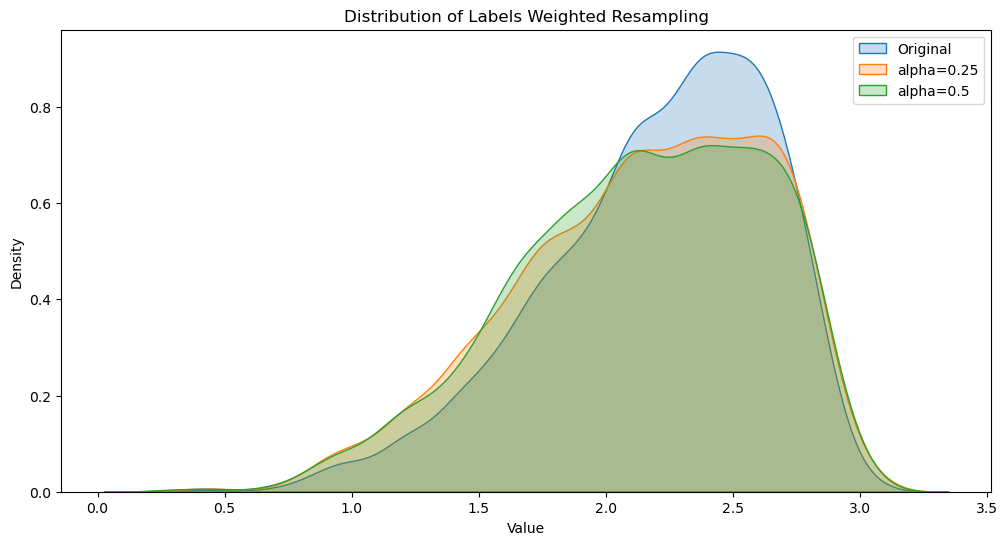

In [13]:
ense_weight_model = DenseWeight(0.25)
dense_weight_model.fit(training_labels)

balanced_train_loader = create_dataloader(train_dataset, 64, dense_weight_model)
balanced_training_labels_alpha_025 = []
for _,_, label in balanced_train_loader:
    balanced_training_labels_alpha_025.extend(label.numpy())

dense_weight_model = DenseWeight(0.5)
dense_weight_model.fit(training_labels)

balanced_train_loader = create_dataloader(train_dataset, 64, dense_weight_model)
balanced_training_labels_alpha_05 = []
for _,_, label in balanced_train_loader:
    balanced_training_labels_alpha_05.extend(label.numpy())


# Set up the matplotlib figure
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# KDE plot of True Labels
sns.kdeplot(training_labels, label='Original', shade=True)

# KDE plot of distribution of resampling
sns.kdeplot(balanced_training_labels_alpha_025, label='alpha=0.25', shade=True)
sns.kdeplot(balanced_training_labels_alpha_05, label='alpha=0.5', shade=True)

# Plot formatting
plt.title('Distribution of Labels Weighted Resampling')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

# Experiment 9: Balanced MSE loss

In [14]:
ex = 'experiments/ex_9'

init_noise_sigma = 1.0
sigma_lr = 0.001
loss = BMCLoss(init_noise_sigma)
model = load_resnet_model('resnet50', num_classes=1)
optimizer = optim.Adam(model.parameters(), lr=LR)
optimizer.add_param_group({'params': loss.noise_sigma, 'lr': sigma_lr, 'name': 'noise_sigma'})
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train_model(model, loss, optimizer, scheduler, train_loader, val_loader, device, ex, epochs=50)

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 6.5856, Train R2: -30.9165, Train weighted MAE: 0.8682,Val Loss: 6.7432, Val R2: -20.2740, Val weighted MAE: 1.1047
Model saved as experiments/ex_9/checkpoint_epoch_1.pth
Epoch 2/50, Train Loss: 6.0564, Train R2: -39.2368, Train weighted MAE: 0.8941,Val Loss: 6.8970, Val R2: -30.3179, Val weighted MAE: 1.5828
Epoch 3/50, Train Loss: 5.4929, Train R2: -37.7566, Train weighted MAE: 0.8528,Val Loss: 5.2837, Val R2: -41.9819, Val weighted MAE: 0.7978
Model saved as experiments/ex_9/checkpoint_epoch_3.pth
Epoch 4/50, Train Loss: 4.8629, Train R2: -33.3707, Train weighted MAE: 0.7894,Val Loss: 4.6444, Val R2: -34.0428, Val weighted MAE: 0.6645
Model saved as experiments/ex_9/checkpoint_epoch_4.pth
Epoch 5/50, Train Loss: 4.1909, Train R2: -28.0894, Train weighted MAE: 0.7005,Val Loss: 3.9493, Val R2: -22.5776, Val weighted MAE: 0.4966
Model saved as experiments/ex_9/checkpoint_epoch_5.pth
Epoch 6/50, Train Loss: 3.4874, Train R2: -22.9997, Train weighted MAE: 0.6142,V